<a href="https://colab.research.google.com/github/satou409/SIGNATE-.ipynb/blob/main/SIGNATE%E3%81%8A%E5%BC%81%E5%BD%93.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# === 0) 読み込み ===
import pandas as pd

train = pd.read_csv('/content/drive/MyDrive/SIGNATE/お弁当/train.csv')
test = pd.read_csv('/content/drive/MyDrive/SIGNATE/お弁当/test.csv')
sample = pd.read_csv('/content/drive/MyDrive/SIGNATE/お弁当/sample.csv',header=None)


Mounted at /content/drive


In [2]:
# =============================
# SIGNATE「お弁当」 二段階残差モデル（統合版）
# - 天気4分類（快晴/晴れ/曇り系/悪天候）
# - 指数減衰トレンド（前半10日除外でfit）
# - 人気スコア：残差の平均（連続値）＋薄いtop/botフラグ
# - menu_category / meat_category / 交互作用 menu_meat
# =============================

# === 0) 準備 ===
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from scipy.optimize import curve_fit

RANDOM_SEED = 42
N_SPLITS    = 5

In [3]:
# === 1) 読み込み・基本前処理 ===
for df in (train, test):
    df["datetime"] = pd.to_datetime(df["datetime"])
    df["payday"]   = df["payday"].fillna(0)
    df["event"]    = df["event"].fillna("なし")
    df["remarks"]  = df["remarks"].fillna("なし")
    df["kcal"]     = df["kcal"].fillna(train["kcal"].mean()).astype(int) # kcal の欠損を平均値で埋めた後に整数に変換

train = train.sort_values("datetime").reset_index(drop=True)
test  = test.sort_values("datetime").reset_index(drop=True)

# === 2) 天気4分類 ===
def bin_weather(s):
    if pd.isna(s): return "不明"
    s = str(s)
    if s == "快晴": return "快晴"
    if s == "晴れ": return "晴れ"
    if s in ["曇", "薄曇", "薄雲"]: return "曇り系"
    if s in ["雨", "雪", "雷電"]:  return "悪天候"
    return "その他"

for df in (train, test):
    df["weather_bin"] = df["weather"].apply(bin_weather)

In [4]:
# === 3) 指数減衰トレンド（前半10日除外でfit） ===
t0 = train["datetime"].min()
train["t"] = (train["datetime"] - t0).dt.days.astype(int)

mask = train["t"] > 10
t = train.loc[mask, "t"].astype(float).values
y = train.loc[mask, "y"].astype(float).values

def exp_decay(t, a, b, c):
    # y = a * exp(-b t) + c
    return a * np.exp(-b * t) + c

c0 = np.median(train["y"].tail(30))
a0 = max(y) - c0 if (max(y) - c0) > 1 else (y.mean() + 1)
b0 = 0.01
bounds = ([0.0, 1e-6, 0.0], [np.inf, 1.0, np.inf])

popt, _ = curve_fit(exp_decay, t, y, p0=(a0, b0, c0), bounds=bounds, maxfev=10000)
a, b, c = popt
print(f"[Trend] a={a:.2f}, b={b:.4f}, c={c:.2f}")

train["trend_decay"]    = exp_decay(train["t"].values, a, b, c)
train["residual_decay"] = train["y"] - train["trend_decay"]

# test側のトレンド付与
test["t"] = (test["datetime"] - t0).dt.days.astype(int)
test["trend_decay"] = exp_decay(test["t"].values, a, b, c)


[Trend] a=117.02, b=0.0069, c=40.76


In [5]:
# === 4) 人気スコア（連続値）＋薄いフラグ ===
TOP_N, BOT_N = 5, 5        # popular/unpopular を弱く入れる

menu_scores = train.groupby("name")["residual_decay"].mean()
top_names = set(menu_scores.sort_values(ascending=False).head(TOP_N).index)
bot_names = set(menu_scores.sort_values(ascending=True).head(BOT_N).index)

for df in (train, test):
    df["menu_score"] = df["name"].map(menu_scores).fillna(0.0)
    df["popular_flag"]   = df["name"].isin(top_names).astype(int)
    df["unpopular_flag"] = df["name"].isin(bot_names).astype(int)


In [6]:
# === 5) メニューカテゴリ（定義） ===
def meat_category(name):
    if any(x in name for x in ["牛", "ビーフ" ,"プルコギ"]):
        return "beef"
    if any(x in name for x in ["豚", "ポーク", "カツ" ,"サムジョン" ,"ロース" , "かつ"]):
        return "pork"
    if any(x in name for x in ["鳥", "チキン", "鶏" ]):
        return "chicken"
    if any(x in name for x in ["肉", "麻婆", "ハンバーグ", "ロコモコ", "メンチ", "マーボ" ]):
        return "meat"
    return "other"

def menu_category(name):
    if any(x in name for x in ["カレー", "かれー"]):
        return "curry"
    if any(x in name for x in ["かつ", "カツ", "野菜あん", "味噌", "すき焼", "生姜", "南部焼き", "山賊", "丼",
                               "ピリ辛焼", "照り", "ご飯", "御飯", "肉じゃが", "唐揚", "から揚", "さんま", "和風", "親子", "ゴーヤ", "しゃぶ", "甘辛煮",
                               "天ぷら", "てんぷら", "南蛮", "シャブ", "味噌カツ", "筑前煮" ,"うどん", "そば", "コロッケ" ,"筍", "スタミナ炒め",
                               "スキヤキ", "塩焼き", "治部煮" ,"梅肉", "柳川", "はさみ揚"]):
        return "japanese"
    if any(x in name for x in ["フライ", "マスタード", "シチュー", "カツ", "ロコモコ", "ハンバーグ", "ステーキ", "フリカッセ", "ムニエル", "タンドリー",
                               "クリーム", "チリソース" ,"ハヤシ" ,"クリーミー", "クリーミ―", "ビーフ", "チキン", "ポーク", "ピザ", "レモンペッパー", "ビュッフェ",
                               "ミックス"]):
        return "western"
    if any(x in name for x in ["回鍋肉", "チャプチェ", "カッシュナッツ", "カシューナッツ", "ニンニクの芽", "キムチ", "マーボ", "麻婆", "青椒肉絲" , "チンジャオ", "サムジョン",
                               "酢豚", "青梗菜牛肉炒め", "八宝菜", "プルコギ", "韓国", "中華", "焼き肉", "炒め" ,"黒酢"]):
        return "chinese"
    return "other"

In [7]:
# === 5) メニューカテゴリ（適用） ===
for df in (train, test):
    df["menu_category"] = df["name"].apply(menu_category)
    df["meat_category"] = df["name"].apply(meat_category)

menu_vocab = sorted(set(train["menu_category"]) | set(test["menu_category"]))
meat_vocab = sorted(set(train["meat_category"]) | set(test["meat_category"]))
for df in (train, test):
    df["menu_category"] = pd.Categorical(df["menu_category"], categories=menu_vocab)
    df["meat_category"] = pd.Categorical(df["meat_category"], categories=meat_vocab)
    df["menu_meat"] = df["menu_category"].astype(str) + "_" + df["meat_category"].astype(str)

In [8]:
# --- カレー補正（menu_scoreブースト） ---
for df in (train, test):
    curry_mask = (df["menu_category"] == "curry")
    df.loc[curry_mask, "menu_score"] *= 1.3  # ブースト倍率は1.1～1.3で調整可

In [9]:
# --- お楽しみメニューのフラグ ---
for df in (train, test):
    df["fun"] = df["remarks"].apply(lambda x: 1 if x == "お楽しみメニュー" else 0)

In [10]:
# --- Temperature binning ---
def bin_temperature(temp):
    if pd.isna(temp):
        return "不明"
    if temp <= 10:
        return "寒"
    if temp >= 30:
        return "暑"
    return "適温"

for df in (train, test):
    df["temp_bin"] = df["temperature"].apply(bin_temperature)

In [21]:
# --- 月特徴量（1..12 をカテゴリとして揃える） ---
for df in (train, test):
    df["month"] = df["datetime"].dt.month.astype(int)

In [34]:
# === 6) 残差を目的変数にして学習（時系列CV） ===
y_trend    = train["trend_decay"].values
y_residual = (train["y"] - train["trend_decay"]).values

cat_cols = ["weather_bin","menu_category","meat_category","week","temp_bin","month"] #あまり効いてないから抜いた,"menu_meat","event"
num_cols = ["payday","kcal","menu_score","popular_flag","unpopular_flag","soldout"] #
use_cols = cat_cols + num_cols

X_all = pd.get_dummies(pd.concat([train[use_cols], test[use_cols]], axis=0),
                       columns=cat_cols, dummy_na=False)
X_tr  = X_all.iloc[:len(train)].reset_index(drop=True)
X_te  = X_all.iloc[len(train):].reset_index(drop=True)

tscv = TimeSeriesSplit(n_splits=N_SPLITS)
oof_resid = np.zeros(len(train))

for fold, (tr_idx, va_idx) in enumerate(tscv.split(X_tr)):
    X_trn, X_val = X_tr.iloc[tr_idx], X_tr.iloc[va_idx]
    y_trn, y_val = y_residual[tr_idx], y_residual[va_idx]

    # 木 or Ridge を選んでOK（木が効きやすい）
    model = RandomForestRegressor(
        n_estimators=400, max_depth=6, min_samples_leaf=4,
        random_state=RANDOM_SEED, n_jobs=-1
    )
    # model = Ridge(alpha=1.0)

    model.fit(X_trn, y_trn)
    oof_resid[va_idx] = model.predict(X_val)
    rmse_fold = mse(train["y"].values[va_idx], y_trend[va_idx] + oof_resid[va_idx])**0.5
    print(f"[Fold {fold}] RMSE = {rmse_fold:.3f}")

rmse_cv = mse(train["y"].values, y_trend + oof_resid)**0.5
print(f"[CV AVG] RMSE = {rmse_cv:.3f}")

[Fold 0] RMSE = 9.655
[Fold 1] RMSE = 11.261
[Fold 2] RMSE = 13.427
[Fold 3] RMSE = 6.355
[Fold 4] RMSE = 7.547
[CV AVG] RMSE = 13.868


In [35]:
# === 7) 特徴量の重要度を確認 ===
# Note: モデルが RandomForestRegressor の場合に実行可能
pd.set_option('display.float_format', '{:.6f}'.format)

if isinstance(model, RandomForestRegressor):
    importances = model.feature_importances_
    feature_names = X_tr.columns
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

    print("Feature Importances:")
    display(feature_importance_df)
else:
    print("Feature importances are only available for tree-based models like RandomForestRegressor.")

Feature Importances:


,feature,importance
2,menu_score,0.885116
1,kcal,0.015954
37,month_11,0.013734
23,week_金,0.010917
3,popular_flag,0.009951
6,weather_bin_快晴,0.008546
19,week_月,0.005284
7,weather_bin_悪天候,0.004953
20,week_木,0.004289
4,unpopular_flag,0.004264


In [36]:
# === 7) 全学習 → test予測 & 提出 ===
final_model = RandomForestRegressor(
    n_estimators=600, max_depth=6, min_samples_leaf=3,
    random_state=RANDOM_SEED, n_jobs=-1
)
final_model.fit(X_tr, y_residual)

# # --- 最終予測（トレンド:残差 のブレンド）---
# alpha = 0.5  # 残差の寄与割合（0.2 = 20%）

# pred_resid_tr = final_model.predict(X_tr)
# pred_resid_te = final_model.predict(X_te)

# # 最終予測 = トレンド + α × 残差予測
# pred_train = y_trend + alpha * pred_resid_tr
# pred_test  = test["trend_decay"].values + alpha * pred_resid_te

# print("Train RMSE (re-fit):", mse(train["y"].values, pred_train)**0.5)

# ==== 書き換え ====
# --- alpha合成 ---
pred_resid_tr = final_model.predict(X_tr)
pred_resid_te = final_model.predict(X_te)

alpha = 0.8
pred_train = y_trend + alpha * pred_resid_tr
pred_test  = test["trend_decay"].values + alpha * pred_resid_te

# ===== カレー強化（型安全＆ベクトル化版） =====
# 学習側の残差（float化）
train["pred_final"]  = np.asarray(pred_train, dtype=float)
train["resid_final"] = train["y"].astype(float) - train["pred_final"]

# 1) カテゴリ単位のバイアス（ベイズ平滑）— FutureWarning対策で observed=True
cat_cnt  = train.groupby("menu_category", observed=True)["resid_final"].size()
cat_mean = train.groupby("menu_category", observed=True)["resid_final"].mean()
global_mean = float(train["resid_final"].mean())
m_cat = 10
cat_bias = (cat_cnt/(cat_cnt+m_cat))*cat_mean + (m_cat/(cat_cnt+m_cat))*global_mean  # float Series

# 2) メニュー名単位（カテゴリへシュリンク）
name_cnt  = train.groupby("name")["resid_final"].size()
name_mean = train.groupby("name")["resid_final"].mean()

# Categorical → object に直してから map（float に統一）
name_cat  = train.drop_duplicates("name").set_index("name")["menu_category"].astype("object")
cat_bias_for_name = name_cat.map(cat_bias).astype(float)               # index: name

# index揃えて λ を作る
m_name = 3
lam = (name_cnt/(name_cnt+m_name)).reindex(name_mean.index).fillna(0.0).astype(float)
cat_bias_for_name = cat_bias_for_name.reindex(name_mean.index).fillna(0.0).astype(float)

# シュリンク（全部 float）
name_bias_shrunk = (lam*name_mean.astype(float) + (1.0-lam)*cat_bias_for_name).astype(float)

# 3) 行ごとの補正量（カレーのみ有効）を“数値配列”で作る
def make_curry_bias(df, name_bias, cat_bias, weight=1.0, cap=55):
    # 名前 → 無ければカテゴリ → 無ければ0.0
    base = df["name"].map(name_bias).reindex(df.index).astype(float)
    base = base.fillna(df["menu_category"].astype("object").map(cat_bias).astype(float))
    base = base.fillna(0.0)
    # 上限キャップ & 重み
    adj = np.clip(base.values, -cap, cap) * float(weight)
    # カレー行だけ有効化（他は0）
    curry_mask = (df["menu_category"] == "curry").to_numpy()
    return adj * curry_mask.astype(float)

# 予測を float ndarray に統一して補正を“加算”する（マスク代入しない）
weight, cap = 2.0, 55  # ←ここで効かせ具合を調整
pred_train = np.asarray(pred_train, dtype=float) + make_curry_bias(train, name_bias_shrunk, cat_bias, weight, cap)
pred_test  = np.asarray(pred_test,  dtype=float) + make_curry_bias(test,  name_bias_shrunk, cat_bias, weight, cap)

# （任意）学習RMSEの再確認
from sklearn.metrics import mean_squared_error as mse
print("Train RMSE after curry-boost (safe):", (mse(train["y"].values, pred_train)**0.5))
# ===== ここまで =====

# 参考：どれだけ“カレー”を上げたのか確認したいとき
print("curry bias (cat):", float(cat_bias.get("curry", 0)))

Train RMSE after curry-boost (safe): 8.257123675312803
curry bias (cat): 3.5167490874385567


|  変更点  |  変更2 | train_RMSE       | submit_RSME        | 備考 |
|---------:| --- |----------------:|-------------------:|-------------------|
|alpha =1  | ---                          | 7.73056769519945 | 11.504179842394409 | 残差1:人気1
|alpha=0.2 | ---                          | 16.85451623558108 | 12.377088013434650	| オレンジの曲線に近い
|alpha=0.9 | ---                          | 8.08483373176701 | 11.322204188774714	| 人気メニューの波を大きく
|alpha=0.8 | ---                          | 8.79646287155774 | 11.209542638031499 | 波を少し緩めた
|alpha=0.5 | ---                          |12.32394436828327 | 11.505851354185634 | 0.8と0.2の中間点
|alpha=0.5 | curry  weight, cap = 1.5, 55 |11.24075030246736 | 12.111659989130626 | カレー大盛
|alpha=0.5 | カレー大盛+"week","event"<br>"temp_bin","soldout"|11.09050751072518 | 11.703056799893712 | +特徴量全部盛り
|alpha=0.5 |curry  weight = 1.5→2.0| 11.32589908813641 | 12.001602457108032 |カレー更に重みづけ
|alpha=0.8 |curry  weight = 1.5→2.0| 8.296742026806852 | 11.113055385446435 |波を揺らす+特徴量全部盛り

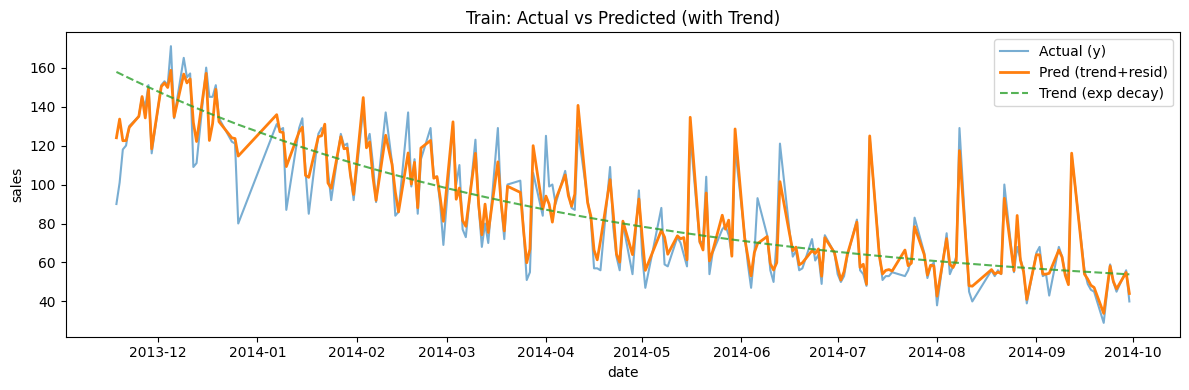

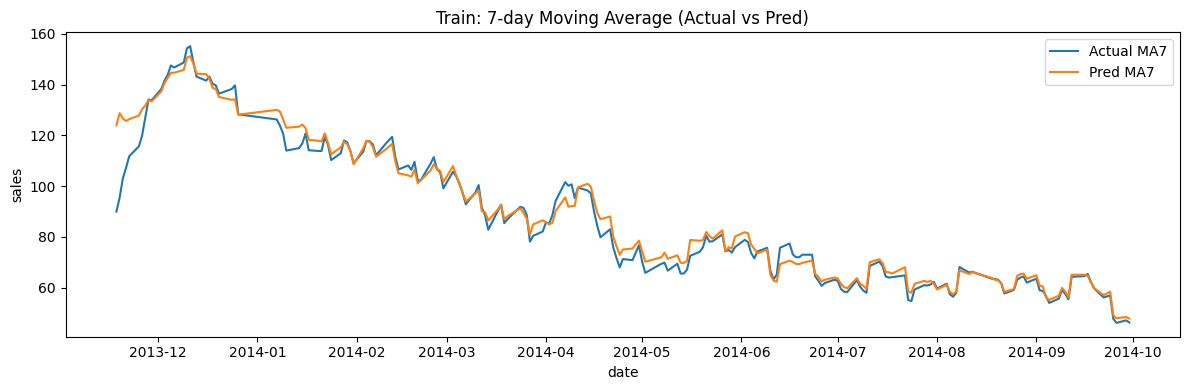

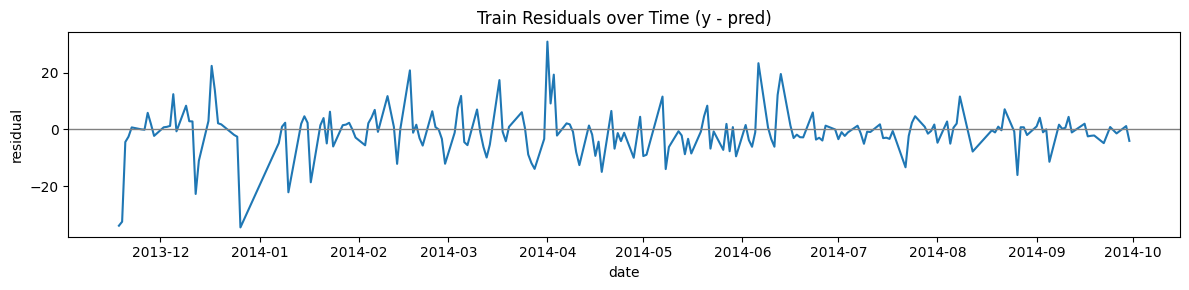

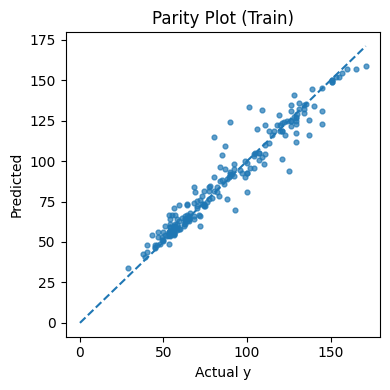

Top-10 absolute errors on train:


,datetime,y,pred_final,residual,name
27,2013-12-26,80,114.607626,-34.607626,酢豚
0,2013-11-18,90,124.000071,-34.000071,厚切りイカフライ
1,2013-11-19,101,133.587512,-32.587512,手作りヒレカツ
85,2014-04-01,125,94.058363,30.941637,メンチカツ
130,2014-06-06,93,69.670721,23.329279,手作りロースカツ
18,2013-12-12,109,131.798343,-22.798343,肉じゃが
21,2013-12-17,145,122.612976,22.387024,手作りヒレカツ
31,2014-01-10,87,109.206967,-22.206967,手作りロースカツ
55,2014-02-17,137,116.203349,20.796651,チンジャオロース
135,2014-06-13,121,101.484471,19.515529,キーマカレー


In [37]:
# ================= 可視化セット =================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) 可視化用テーブル作成（学習データ）
vis = train[["datetime","y","trend_decay", "name"]].copy() # Add "name" column
vis["pred_final"] = np.asarray(pred_train)               # 最終予測 = trend + 残差予測
vis["residual"]   = vis["y"] - vis["pred_final"]         # 学習上の最終残差
vis = vis.sort_values("datetime").reset_index(drop=True)

# 2) 全期間：実測 vs 予測（＆トレンド）
plt.figure(figsize=(12,4))
plt.plot(vis["datetime"], vis["y"],          label="Actual (y)", alpha=0.6)
plt.plot(vis["datetime"], vis["pred_final"], label="Pred (trend+resid)", linewidth=2)
plt.plot(vis["datetime"], vis["trend_decay"],label="Trend (exp decay)", linestyle="--", alpha=0.8)
plt.title("Train: Actual vs Predicted (with Trend)")
plt.xlabel("date"); plt.ylabel("sales"); plt.legend(); plt.tight_layout()
plt.show()

# 3) ノイズを見る：7日移動平均でスムージング比較
vis["y_ma7"]    = vis["y"].rolling(7, min_periods=1).mean()
vis["pred_ma7"] = vis["pred_final"].rolling(7, min_periods=1).mean()
plt.figure(figsize=(12,4))
plt.plot(vis["datetime"], vis["y_ma7"],    label="Actual MA7")
plt.plot(vis["datetime"], vis["pred_ma7"], label="Pred MA7")
plt.title("Train: 7-day Moving Average (Actual vs Pred)")
plt.xlabel("date"); plt.ylabel("sales"); plt.legend(); plt.tight_layout()
plt.show()

# 4) 残差の推移（系統誤差チェック）
plt.figure(figsize=(12,3))
plt.plot(vis["datetime"], vis["residual"])
plt.axhline(0, color="gray", linewidth=1)
plt.title("Train Residuals over Time (y - pred)")
plt.xlabel("date"); plt.ylabel("residual"); plt.tight_layout()
plt.show()

# 5) 実測 vs 予測 の散布図（当たり具合）
plt.figure(figsize=(4,4))
plt.scatter(vis["y"], vis["pred_final"], s=12, alpha=0.7)
m = max(vis["y"].max(), vis["pred_final"].max())
plt.plot([0,m],[0,m], linestyle="--")  # 完全一致ライン
plt.title("Parity Plot (Train)")
plt.xlabel("Actual y"); plt.ylabel("Predicted")
plt.tight_layout(); plt.show()

# 6) “ズレが大きい日”トップ10（デバッグ用）
worst = vis.assign(abs_err = vis["residual"].abs()) \
           .nlargest(10, "abs_err")[["datetime","y","pred_final","residual", "name"]] # Add "name" column
print("Top-10 absolute errors on train:")
display(worst)

In [26]:
# ===== 提出ファイル作成（SIGNATE仕様） =====
# 念のためのクリップ＆整数化（不要なら外してOK）
pred_sig = np.clip(pred_test, 0, None)
pred_sig = np.rint(pred_sig).astype(int)

# 日付は "yyyy-m-d"（月/日ともゼロ埋めなし）に整形
sub = pd.DataFrame({
    "date":  test["datetime"].dt.year.astype(str) + "-" +
             test["datetime"].dt.month.astype(str) + "-" +
             test["datetime"].dt.day.astype(str),
    "y": pred_sig
})

# 並び順を担保（時系列で）
sub = sub.sort_values("date").reset_index(drop=True)

# ヘッダーなし・インデックスなしでUTF-8保存（提出用）
submit_path = "/content/submission.csv"
sub.to_csv(submit_path, index=False, header=False, encoding="utf-8")
print("Saved (UTF-8, headerless):", submit_path)

# --- Excelで開く用（日本語Windowsの文字化け回避したい時だけ）---
# sub.to_csv("/content/submission_sjis.csv", index=False, header=False, encoding="cp932")


Saved (UTF-8, headerless): /content/submission.csv


--- Visualization for Fold 0 ---


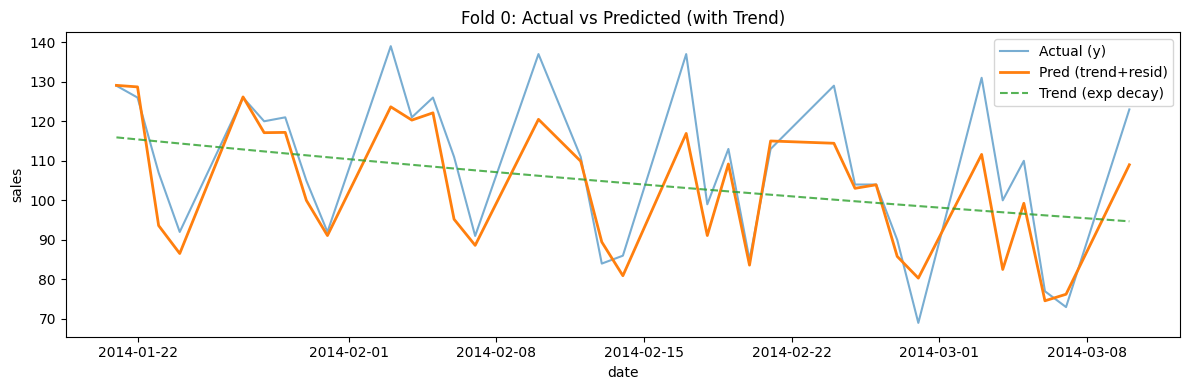

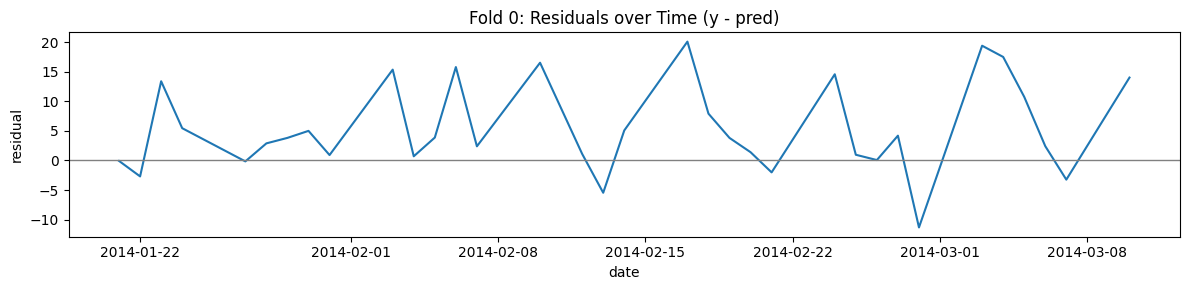

[Fold 0] RMSE = 9.321
----------------------------------------
--- Visualization for Fold 1 ---


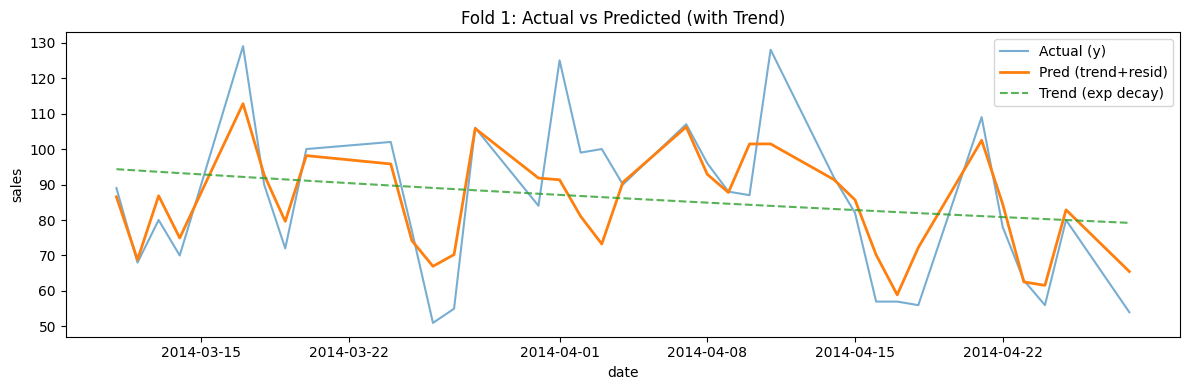

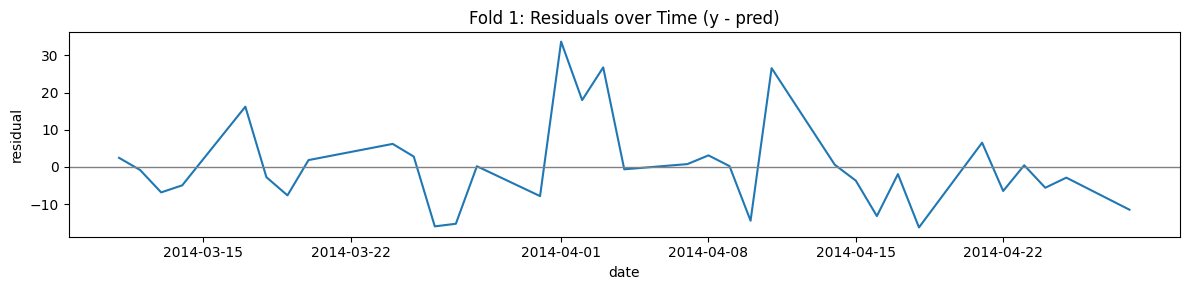

[Fold 1] RMSE = 11.895
----------------------------------------
--- Visualization for Fold 2 ---


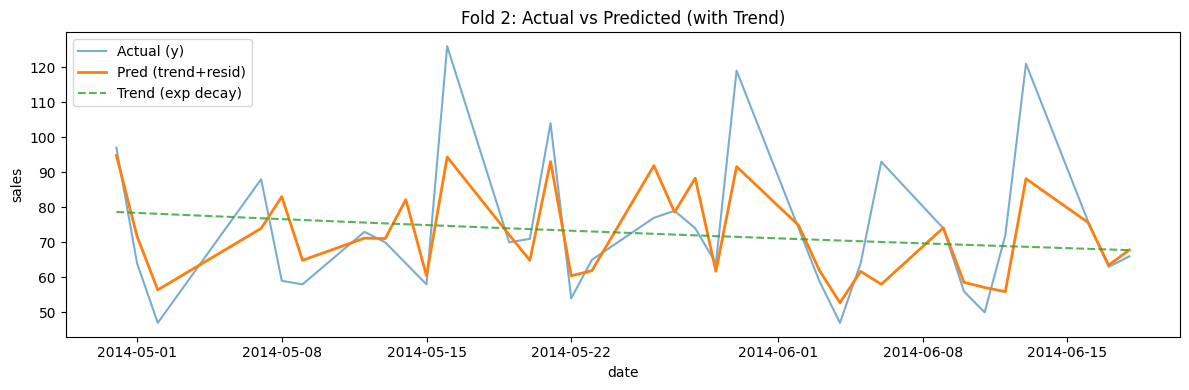

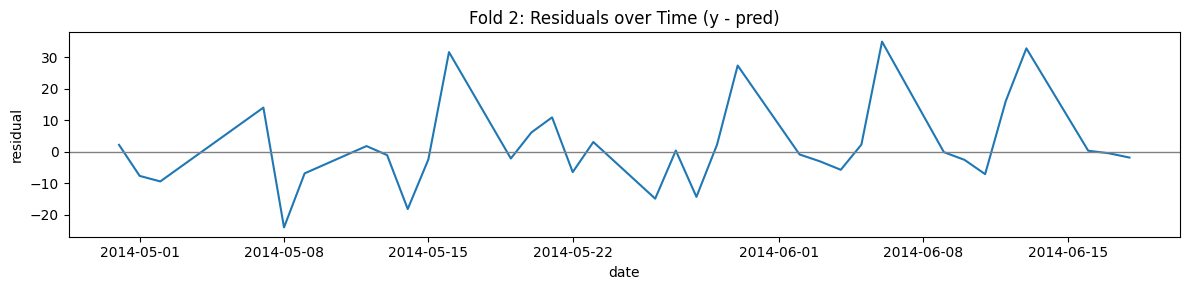

[Fold 2] RMSE = 13.702
----------------------------------------
--- Visualization for Fold 3 ---


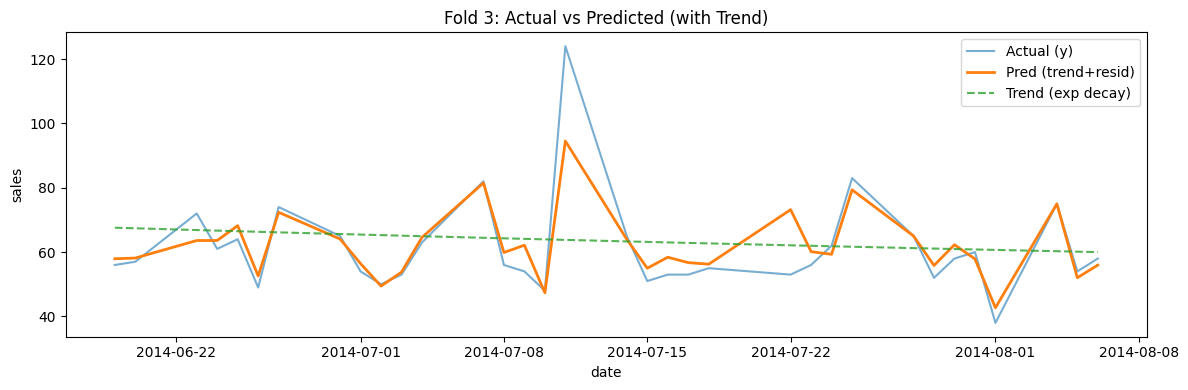

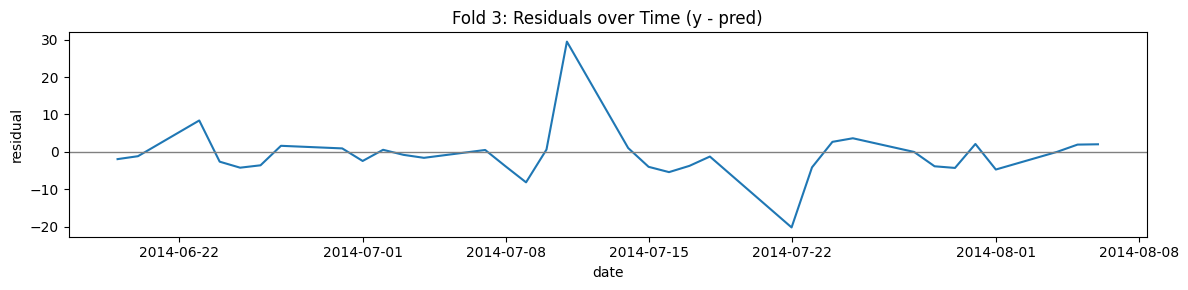

[Fold 3] RMSE = 6.969
----------------------------------------
--- Visualization for Fold 4 ---


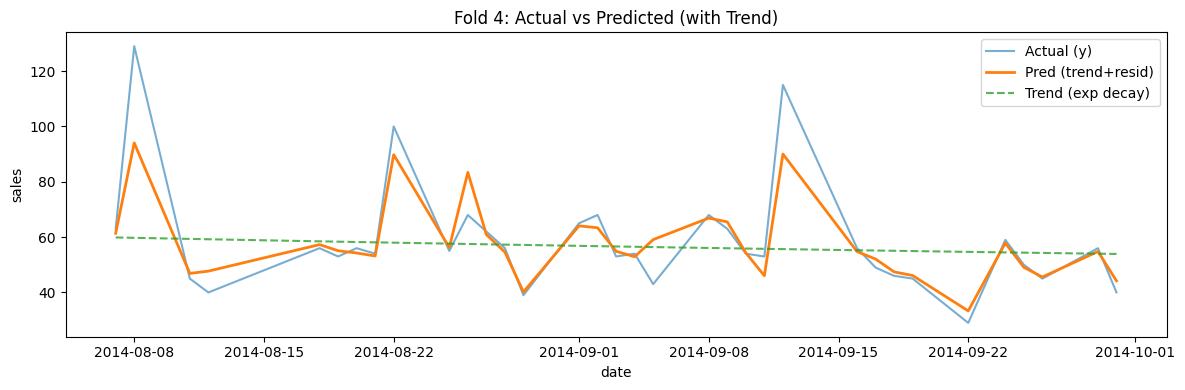

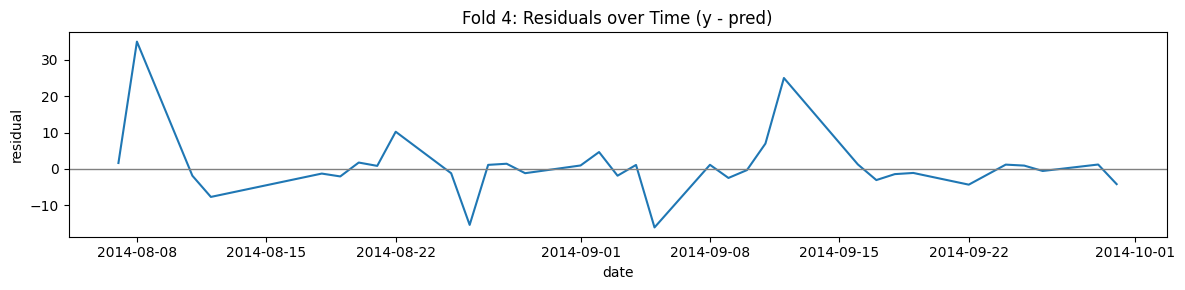

[Fold 4] RMSE = 8.856
----------------------------------------


In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Use the same variables and parameters as in the previous cells
tscv = TimeSeriesSplit(n_splits=N_SPLITS)
X = X_tr
y = train["y"].values  # Use the original target variable for visualization
y_trend = train["trend_decay"].values
y_residual = (y - y_trend) # Removed .values here

# List to store visualization data for each fold
vis_folds_data = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X, y_residual)): # Split based on residuals
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold_residual, y_val_fold_residual = y_residual[train_idx], y_residual[val_idx] # Use residual for training

    # Train the model on the residual
    model = RandomForestRegressor(
        n_estimators=400, max_depth=6, min_samples_leaf=4,
        random_state=RANDOM_SEED, n_jobs=-1
    )
    model.fit(X_train_fold, y_train_fold_residual)
    pred_val_residual = model.predict(X_val_fold)

    # Calculate the final prediction for the validation set of this fold
    pred_val_final = y_trend[val_idx] + alpha * pred_val_residual # Add back the trend and apply alpha

    # --- Visualization for the current fold ---
    print(f"--- Visualization for Fold {fold} ---")

    # Create a DataFrame for visualization
    vis_fold = train.iloc[val_idx].copy()
    vis_fold["pred_final"] = pred_val_final
    vis_fold["residual"] = vis_fold["y"] - vis_fold["pred_final"]

    # Store the visualization data for this fold
    vis_folds_data.append(vis_fold)

    # 1) Actual vs Predicted (with Trend) for the fold
    plt.figure(figsize=(12, 4))
    plt.plot(vis_fold["datetime"], vis_fold["y"], label="Actual (y)", alpha=0.6)
    plt.plot(vis_fold["datetime"], vis_fold["pred_final"], label="Pred (trend+resid)", linewidth=2)
    plt.plot(vis_fold["datetime"], vis_fold["trend_decay"], label="Trend (exp decay)", linestyle="--", alpha=0.8)
    plt.title(f"Fold {fold}: Actual vs Predicted (with Trend)")
    plt.xlabel("date")
    plt.ylabel("sales")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2) Residuals over Time for the fold
    plt.figure(figsize=(12, 3))
    plt.plot(vis_fold["datetime"], vis_fold["residual"])
    plt.axhline(0, color="gray", linewidth=1)
    plt.title(f"Fold {fold}: Residuals over Time (y - pred)")
    plt.xlabel("date")
    plt.ylabel("residual")
    plt.tight_layout()
    plt.show()

    # Calculate and print RMSE for the fold
    rmse_fold = mean_squared_error(vis_fold["y"], vis_fold["pred_final"])**0.5 # Calculate RMSE by taking the square root
    print(f"[Fold {fold}] RMSE = {rmse_fold:.3f}")
    print("-" * 40)

In [33]:
# Fold 2のデータを取得 (リストのインデックスは0から始まるため、Fold 2はインデックス1になります)
# Update: Index for Fold 2 is actually 2 based on the output of the loop in cell BH1O595Nv7xz
fold_1_data = vis_folds_data[3]

# 指定されたカラムを表示
display(fold_1_data[['datetime', 'name', 'y', 'pred_final', 'menu_category', 'weather', 'kcal']])

,datetime,name,y,pred_final,menu_category,weather,kcal
139,2014-06-19,アジ唐揚げ南蛮ソース,56,60.106982,japanese,晴れ,430
140,2014-06-20,炊き込みご飯,57,62.230373,japanese,薄曇,407
141,2014-06-23,マーボ茄子,72,73.223572,chinese,曇,421
142,2014-06-24,鶏のトマトシチュー,61,65.046590,western,曇,430
143,2014-06-25,豚の冷しゃぶ,64,66.953802,japanese,雨,420
144,2014-06-26,キスと野菜の天ぷら,49,58.706635,japanese,曇,414
145,2014-06-27,牛丼,74,63.509421,japanese,雨,404
146,2014-06-30,鶏の塩から揚げ,65,74.063422,japanese,薄曇,435
147,2014-07-01,カレイ唐揚げ夏野菜あん,54,64.855682,japanese,曇,362
148,2014-07-02,タンドリーチキン,50,62.293392,western,快晴,363


In [39]:
subuta_data = train[train['name'].str.contains('カレー')]

display(subuta_data[['datetime','name','menu_category','week','y','pred_final','remarks','weather','temp_bin']])

,datetime,name,menu_category,week,y,pred_final,remarks,weather,temp_bin
28,2014-01-07,カレー入りソーセージカツ,curry,火,131,130.152226,なし,快晴,寒
38,2014-01-22,手作りひれかつとカレー,curry,水,126,125.401073,なし,快晴,寒
40,2014-01-24,鶏のレモンペッパー焼orカレー,curry,金,92,93.549111,鶏のレモンペッパー焼（50食）、カレー（42食）,快晴,適温
46,2014-02-03,ハンバーグカレーソース,curry,月,139,137.126576,なし,晴れ,適温
59,2014-02-21,酢豚orカレー,curry,金,113,113.915021,酢豚（28食）、カレー（85食）,快晴,寒
65,2014-03-03,ハンバーグカレーソース,curry,月,131,124.667646,なし,曇,寒
72,2014-03-12,ビーフカレー,curry,水,68,69.862235,なし,快晴,適温
83,2014-03-28,キーマカレー,curry,金,106,112.383011,お楽しみメニュー,快晴,適温
93,2014-04-11,チキンカレー,curry,金,128,125.206348,お楽しみメニュー,快晴,適温
115,2014-05-16,ポークカレー,curry,金,126,116.351521,お楽しみメニュー,快晴,適温


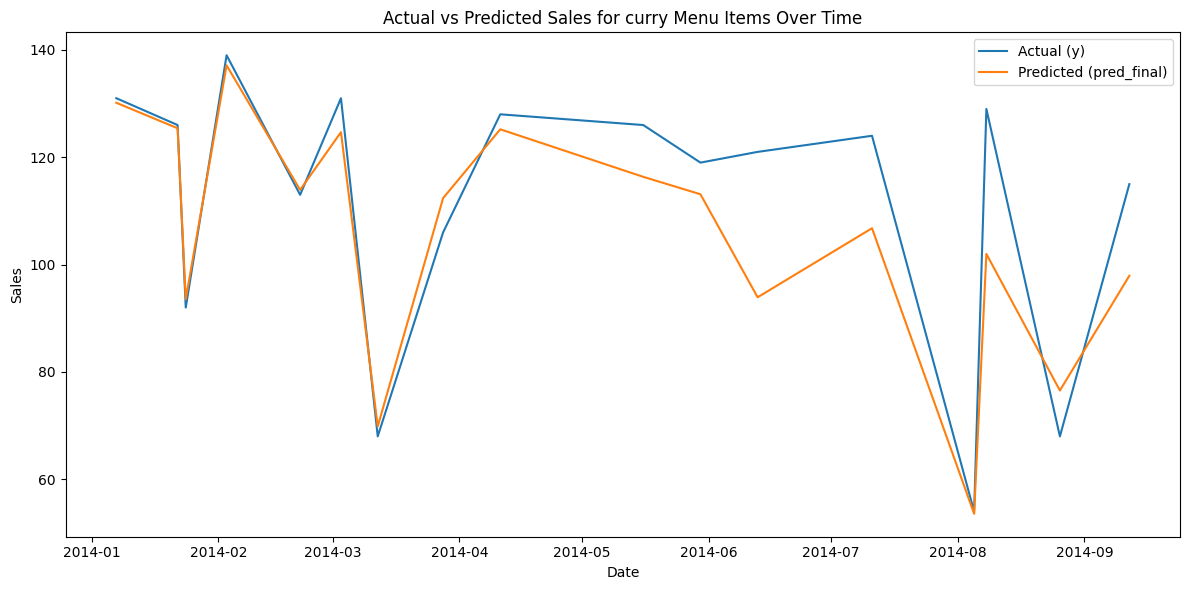

In [41]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(subuta_data['datetime'], subuta_data['y'], label='Actual (y)')
plt.plot(subuta_data['datetime'], subuta_data['pred_final'], label='Predicted (pred_final)')
plt.title('Actual vs Predicted Sales for curry Menu Items Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()